# Attribution Maps Workflow
This notebook demonstrates loading models, training them, printing model layers, and applying the Grad-CAM workflow.

In [58]:
# Enable autoreload for imports
%load_ext autoreload
%autoreload 2
# Import necessary modules
from models import PneumoniaCNN, PneumoniaResNet
from grad_cam import GradCAM
from integrated_gradients import integrated_gradients, IntegratedGradients
from train_cnn import train_net, eval_net
from dataloaders import train_loader, val_loader, test_loader
import cv2

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torchvision.transforms import GaussianBlur
import os
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'c:\\Users\\paesc\\OneDrive\\docs\\projects\\Pneumonia-XRay-Prediction-Interpretability\\notebooks'

In [59]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = PneumoniaCNN().to(device)
cnn_model_random = PneumoniaCNN().to(device)

# load the state dicts
cnn_model.load_state_dict(torch.load("../model_state_dicts/cnn_model.pt"))
cnn_model_random.load_state_dict(torch.load("../model_state_dicts/cnn_model_randomized.pt"))

<All keys matched successfully>

In [60]:
# Print model layers to select layer later on
print("CNN Model Layers:")
print(cnn_model)

for name, layer in cnn_model.named_modules():
    print(f"Layer: {name}, Type: {type(layer)}")

# print("ResNet Model Layers:")
# print(resnet_model)

CNN Model Layers:
PneumoniaCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Layer: , Type: <class 'models.PneumoniaCNN'>
Layer: conv1, Type: <class 'torch.nn.modules.conv.Conv2d'>
Layer: pool1, Type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer: conv2, Type: <class 'torch.nn.modules.conv.Conv2d'>
Layer: pool2, Type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer: fc1, Type: <class 'torch.nn.modules.linear.Linear'>
Layer: fc2, Type: <class 'torch.nn.modules.linear.Linear'>


In [61]:
def get_conv_layer_by_index(model, index):
    """
    Get the nth convolutional layer from a model
    
    Args:
        model: PyTorch model
        index (int): Index of the convolutional layer (0-based)
        
    Returns:
        layer: The selected convolutional layer
    """
    conv_layers = []
    
    # Collect all conv layers in the model
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            conv_layers.append((name, layer))
    
    if index < 0 or index >= len(conv_layers):
        raise ValueError(f"Index {index} is out of range. Model has {len(conv_layers)} convolutional layers.")
    
    return conv_layers[index][1]  # Return the layer object

In [62]:
# Define get_samples_by_label function
def get_samples_by_label(loader, label, n=5):
    """
    Get n samples of a specific label from the data loader
    
    Args:
        loader: Data loader
        label (int): Label to filter by
        n (int): Number of samples to get
        
    Returns:
        samples: List of samples with the specified label
    """
    samples = []
    
    for images, labels in loader:
        for i in range(len(labels)):
            if labels[i] == label and len(samples) < n:
                samples.append(images[i])
            if len(samples) >= n:
                break
        if len(samples) >= n:
            break
    
    return samples


def visualize_comparisons(idx, conv_layer_idx, models, loader, n=5, model_names=None):
    """
    Visualize comparison between models using Grad-CAM and Integrated Gradients
    
    Args:
        idx (int): Index of the sample to visualize
        conv_layer_idx (int): Index of the convolutional layer to use
        models (list): List of models to compare
        loader: Data loader to get samples from
        n (int): Number of samples to get from each class
        model_names (list, optional): List of names for the models for plot titles. Default is ["Model 1", "Model 2"]
    """
    # Set default model names if not provided
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(models))]
    
    # Ensure we have enough model names
    if len(model_names) < len(models):
        model_names.extend([f"Model {i+1}" for i in range(len(model_names), len(models))])
    
    # Get samples
    images_normal = get_samples_by_label(loader, 0, n=n)
    images_pneumonia = get_samples_by_label(loader, 1, n=n)
    
    # Get appropriate target layers by index
    target_layers = [get_conv_layer_by_index(model, conv_layer_idx) for model in models]

    # Initialize Grad-CAMs for all models
    grad_cams = [GradCAM(model, layer) for model, layer in zip(models, target_layers)]
    
    # Initialize Integrated Gradients for all models
    igs = [IntegratedGradients(model, steps=50) for model in models]
    
    # Select images
    image_normal = images_normal[idx]
    image_pneumonia = images_pneumonia[idx]
    
    # Prepare input tensors
    input_tensor_normal = image_normal.unsqueeze(0).to(device)
    input_tensor_pneumonia = image_pneumonia.unsqueeze(0).to(device)
    
    # Create blurred baselines
    blur_transform = GaussianBlur(kernel_size=11)
    baseline_normal = blur_transform(image_normal).unsqueeze(0).to(device)
    baseline_pneumonia = blur_transform(image_pneumonia).unsqueeze(0).to(device)
    
    # Generate attributions for Integrated Gradients
    attr_normal = [ig.generate_attributions(input_tensor_normal, target_class=0, baseline=baseline_normal) for ig in igs]
    attr_pneumonia = [ig.generate_attributions(input_tensor_pneumonia, target_class=1, baseline=baseline_pneumonia) for ig in igs]
    
    # Process attributions
    attr_map_normal = [ig.process_attributions(attr) for ig, attr in zip(igs, attr_normal)]
    attr_map_pneumonia = [ig.process_attributions(attr) for ig, attr in zip(igs, attr_pneumonia)]
    
    # Generate CAMs
    cam_normal = [gc.generate_cam(input_tensor_normal) for gc in grad_cams]
    cam_pneumonia = [gc.generate_cam(input_tensor_pneumonia) for gc in grad_cams]
    
    # Process original images for display
    orig_normal = image_normal.permute(1, 2, 0).numpy()
    orig_normal = (orig_normal - orig_normal.min()) / (orig_normal.max() - orig_normal.min())
    orig_normal = (orig_normal * 255).astype(np.uint8)
    
    orig_pneumonia = image_pneumonia.permute(1, 2, 0).numpy()
    orig_pneumonia = (orig_pneumonia - orig_pneumonia.min()) / (orig_pneumonia.max() - orig_pneumonia.min())
    orig_pneumonia = (orig_pneumonia * 255).astype(np.uint8)
    
    # Create overlays
    overlay_ig_normal = [ig.overlay_attributions(orig_normal.copy(), attr_map) for ig, attr_map in zip(igs, attr_map_normal)]
    overlay_ig_pneumonia = [ig.overlay_attributions(orig_pneumonia.copy(), attr_map) for ig, attr_map in zip(igs, attr_map_pneumonia)]
    
    overlay_cam_normal = [gc.overlay_cam(orig_normal.copy(), cam) for gc, cam in zip(grad_cams, cam_normal)]
    overlay_cam_pneumonia = [gc.overlay_cam(orig_pneumonia.copy(), cam) for gc, cam in zip(grad_cams, cam_pneumonia)]
    
    # Create figure
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    
    # Define subplot labels A-J for publication-ready figures
    # Top row: A-E, Bottom row: F-J
    subplot_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    
    # Original images (first column)
    axes[0, 0].imshow(orig_normal)
    axes[0, 0].set_title("Original (Normal)")
    axes[0, 0].axis("off")
    axes[0, 0].text(0.05, 0.05, subplot_labels[0], transform=axes[0, 0].transAxes, 
                    fontsize=14, fontweight='bold', color='white', 
                    bbox=dict(facecolor='black', alpha=0.8))
    
    axes[1, 0].imshow(orig_pneumonia)
    axes[1, 0].set_title("Original (Pneumonia)")
    axes[1, 0].axis("off")
    axes[1, 0].text(0.05, 0.05, subplot_labels[5], transform=axes[1, 0].transAxes, 
                    fontsize=14, fontweight='bold', color='white', 
                    bbox=dict(facecolor='black', alpha=0.8))
    
    # Model 1 (second and third columns)
    axes[0, 1].imshow(overlay_ig_normal[0])
    axes[0, 1].set_title(f"IG {model_names[0]} (Normal)")
    axes[0, 1].axis("off")
    axes[0, 1].text(0.05, 0.05, subplot_labels[1], transform=axes[0, 1].transAxes, 
                    fontsize=14, fontweight='bold', color='white', 
                    bbox=dict(facecolor='black', alpha=0.8))
    
    axes[0, 2].imshow(overlay_cam_normal[0])
    axes[0, 2].set_title(f"Grad-CAM {model_names[0]} (Normal)")
    axes[0, 2].axis("off")
    axes[0, 2].text(0.05, 0.05, subplot_labels[2], transform=axes[0, 2].transAxes, 
                    fontsize=14, fontweight='bold', color='white', 
                    bbox=dict(facecolor='black', alpha=0.8))
    
    axes[1, 1].imshow(overlay_ig_pneumonia[0])
    axes[1, 1].set_title(f"IG {model_names[0]} (Pneumonia)")
    axes[1, 1].axis("off")
    axes[1, 1].text(0.05, 0.05, subplot_labels[6], transform=axes[1, 1].transAxes, 
                    fontsize=14, fontweight='bold', color='white', 
                    bbox=dict(facecolor='black', alpha=0.8))
    
    axes[1, 2].imshow(overlay_cam_pneumonia[0])
    axes[1, 2].set_title(f"Grad-CAM {model_names[0]} (Pneumonia)")
    axes[1, 2].axis("off")
    axes[1, 2].text(0.05, 0.05, subplot_labels[7], transform=axes[1, 2].transAxes, 
                    fontsize=14, fontweight='bold', color='white', 
                    bbox=dict(facecolor='black', alpha=0.8))
    
    # Model 2 (fourth and fifth columns)
    axes[0, 3].imshow(overlay_ig_normal[1])
    axes[0, 3].set_title(f"IG {model_names[1]} (Normal)")
    axes[0, 3].axis("off")
    axes[0, 3].text(0.05, 0.05, subplot_labels[3], transform=axes[0, 3].transAxes, 
                    fontsize=14, fontweight='bold', color='white', 
                    bbox=dict(facecolor='black', alpha=0.8))
    
    axes[0, 4].imshow(overlay_cam_normal[1])
    axes[0, 4].set_title(f"Grad-CAM {model_names[1]} (Normal)")
    axes[0, 4].axis("off")
    axes[0, 4].text(0.05, 0.05, subplot_labels[4], transform=axes[0, 4].transAxes, 
                    fontsize=14, fontweight='bold', color='white', 
                    bbox=dict(facecolor='black', alpha=0.8))
    
    axes[1, 3].imshow(overlay_ig_pneumonia[1])
    axes[1, 3].set_title(f"IG {model_names[1]} (Pneumonia)")
    axes[1, 3].axis("off")
    axes[1, 3].text(0.05, 0.05, subplot_labels[8], transform=axes[1, 3].transAxes, 
                    fontsize=14, fontweight='bold', color='white', 
                    bbox=dict(facecolor='black', alpha=0.8))
    
    axes[1, 4].imshow(overlay_cam_pneumonia[1])
    axes[1, 4].set_title(f"Grad-CAM {model_names[1]} (Pneumonia)")
    axes[1, 4].axis("off")
    axes[1, 4].text(0.05, 0.05, subplot_labels[9], transform=axes[1, 4].transAxes, 
                    fontsize=14, fontweight='bold', color='white', 
                    bbox=dict(facecolor='black', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'models': models,
        'target_layers': target_layers,
        'conv_layer_idx': conv_layer_idx,
        'model_names': model_names
    }

In [63]:
# Check available convolutional layers
conv_layers = []
for name, layer in cnn_model.named_modules():
    if isinstance(layer, nn.Conv2d):
        conv_layers.append((name, layer))
print(f"Found {len(conv_layers)} convolutional layers:")
for i, (name, _) in enumerate(conv_layers):
    print(f"  {i}: {name}")

Found 2 convolutional layers:
  0: conv1
  1: conv2


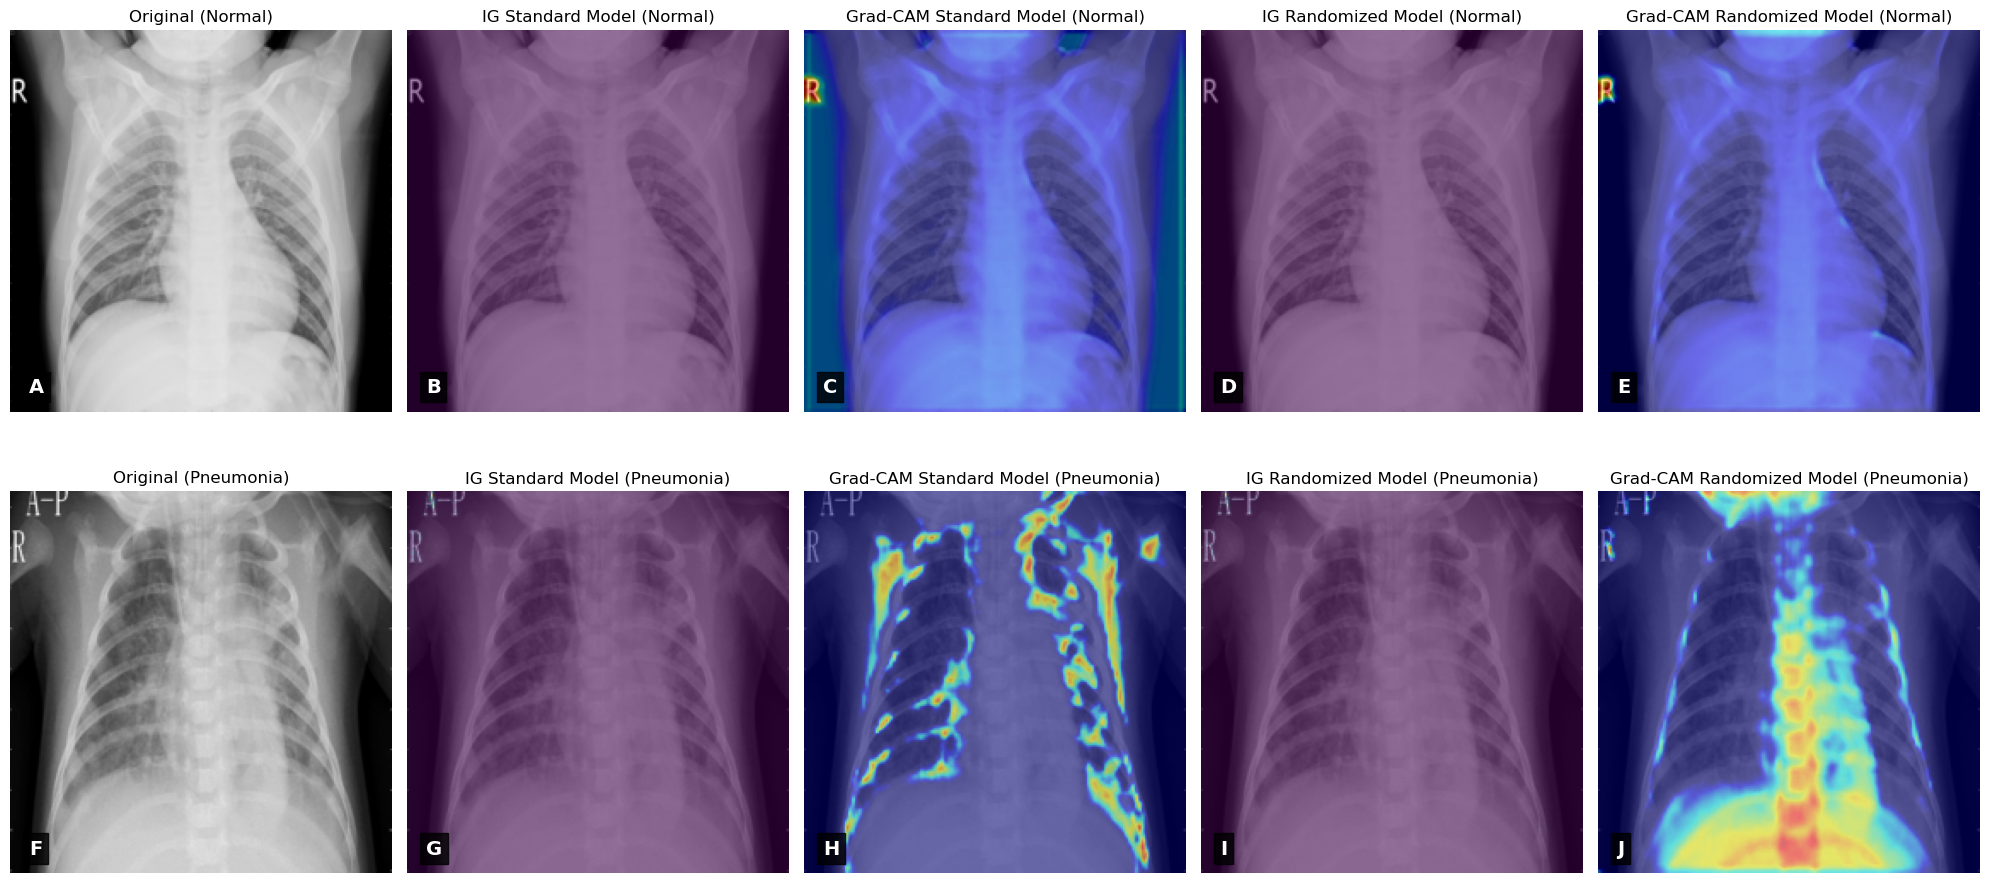


Target layers used:
Model 1: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Model 2: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [64]:
# Example usage of the new function with two models and layer index 1 (second conv layer)
result = visualize_comparisons(
    idx=0,                             # First sample
    conv_layer_idx=1,                  # Second convolutional layer (index 1)
    models=[cnn_model, cnn_model_random],  # Compare trained vs randomized model
    loader=val_loader,                 # Use validation data
    n=5,                               # Get 5 samples from each class
    model_names=["Standard Model", "Randomized Model"]  # Custom model names
)

print(f"\nTarget layers used:")
for i, layer in enumerate(result['target_layers']):
    print(f"Model {i+1}: {layer}")

## Layer Analysis

Let's compare the attribution maps generated from different convolutional layers to see how the network's focus changes throughout the layers.

Comparing first conv layer (idx=0) with second conv layer (idx=1):


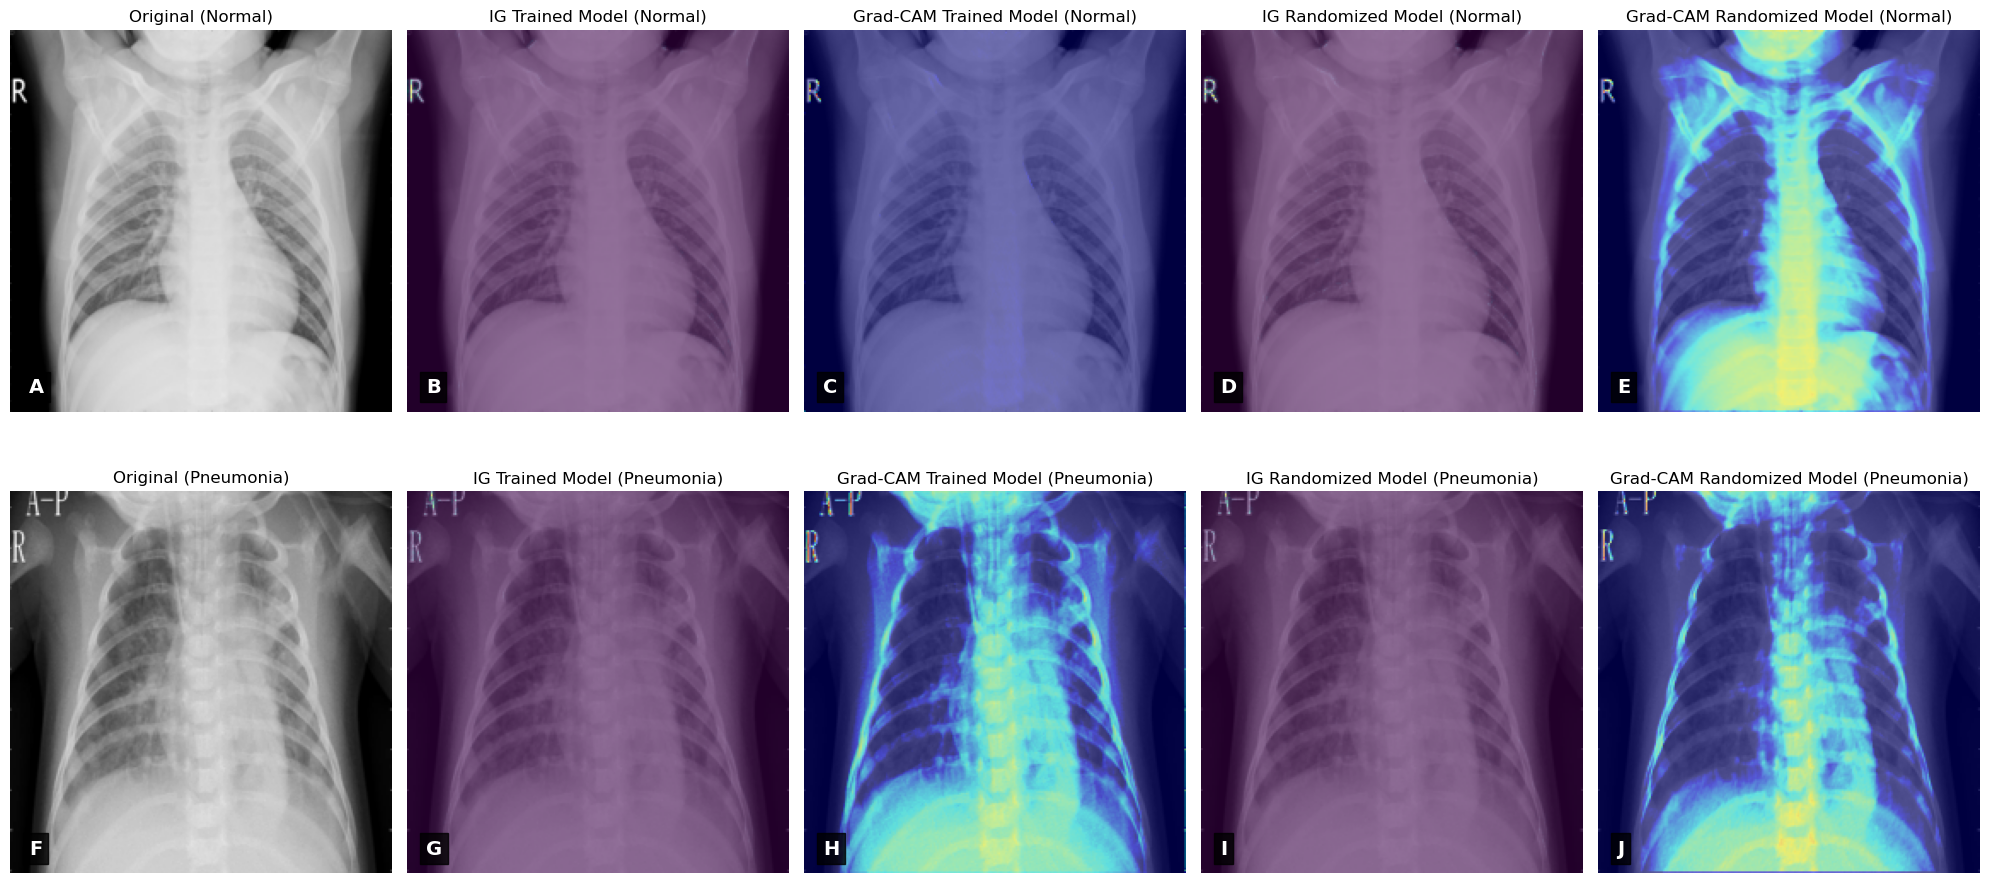

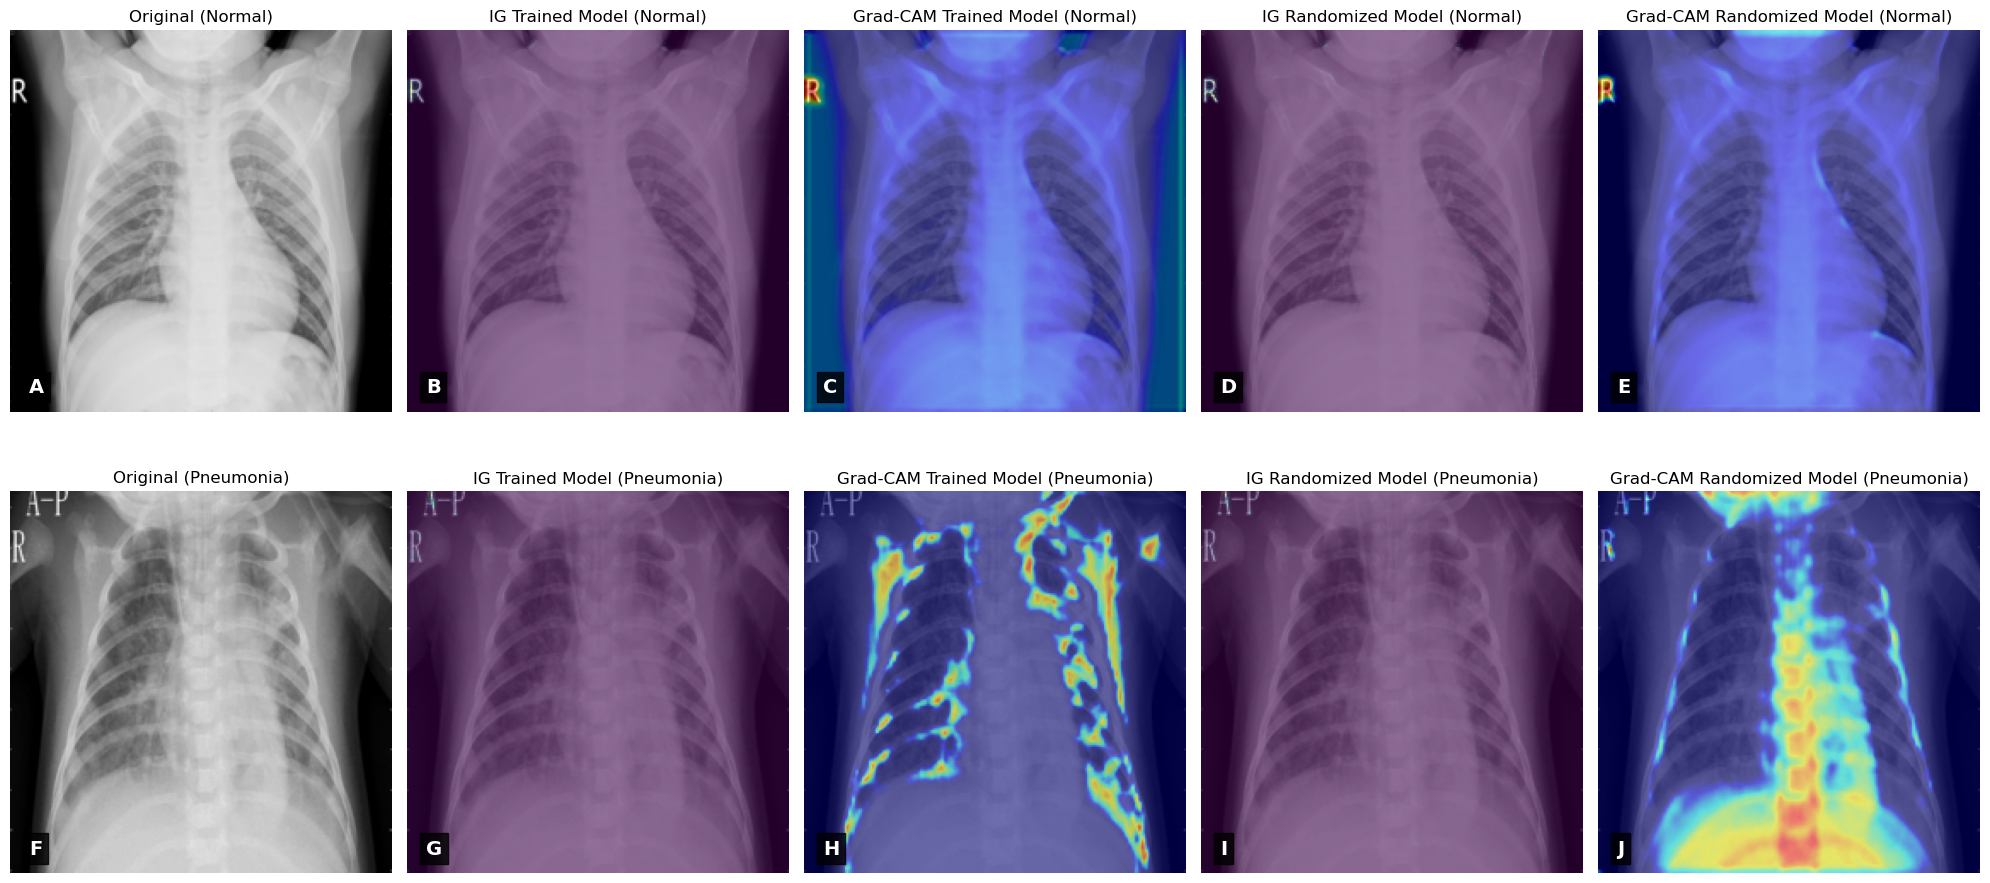

In [65]:
# Compare attributions from first and second conv layers
print("Comparing first conv layer (idx=0) with second conv layer (idx=1):")
result_conv1 = visualize_comparisons(
    idx=0,                             # First sample
    conv_layer_idx=0,                  # First convolutional layer
    models=[cnn_model, cnn_model_random],
    loader=val_loader,
    n=5,
    model_names=["Trained Model", "Randomized Model"]
)

result_conv2 = visualize_comparisons(
    idx=0,                             # Same sample
    conv_layer_idx=1,                  # Second convolutional layer
    models=[cnn_model, cnn_model_random],
    loader=val_loader,
    n=5,
    model_names=["Trained Model", "Randomized Model"]
)